In [ ]:
#cannot work

In [1]:
import numpy as np
import os
import sys
import scipy
import cv2
import gc

#解析使用
import xml
from xml.etree import ElementTree as ET

from glob import glob

import keras.backend as K
from keras.utils import to_categorical

import imageio
from skimage import transform

from matplotlib import pyplot as plt
%matplotlib inline


C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow.python.ops import nn
from tensorflow.contrib import slim

In [3]:
import warnings

warnings.filterwarnings(action='error')

In [4]:
TRAIN_DATA_PATH = '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/'
TEST_DATA_PATH = '../../tensorflow2/dataset/VOC2012test/JPEGImages/'

TRAIN_XML_PATH = '../../tensorflow2/dataset/VOCtrainval_11-May-2012/Annotations/'
TEST_XML_PATH = '../../tensorflow2/dataset/VOC2012test/Annotations/'

CLASSES_NUM = 20

STR = [
    'background', #SSD有单独的背景
    'person',
    'bird','cat','cow','dog','horse','sheep',
    'aeroplane','bicycle','boat','bus','car','motorbike','train',
    'bottle','chair','diningtable','pottedplant','sofa','tvmonitor'
]

LABEL2STR = {idx:value for idx , value in enumerate(STR)}
STR2LABEL = {value:key for key,value in LABEL2STR.items()}
#STR2LABEL = {value:idx for idx , value in enumerate(STR)}

STR2LABEL['none'] = 'none' #先不使用part部分 只进行naive目标检测

#目标检测相关
IoU_THRESHOLD = 0.5

#SVM相关
SVM_IoU_THRESHOLD = 0.3

#NMS相关
NMS_IoU_THRESHOLD = 0.3 #or ~0.5

#bbox回归
BBOX_REGRESS_IoU_THRESHOLD = 0.6

In [5]:
xml_file_names_train = glob(TRAIN_XML_PATH + '*') #所有的xml文件 完整路径

#从xml文件中读出图片相关的信息

def xml_parse(xml_file):
    '''
    return filename , shape , name_boxes , crop_boxes
    xml文件中的shape格式为 (width height 3)
    '''
    xml_file = xml.dom.minidom.parse(xml_file)
    xml_file_docu_ele = xml_file.documentElement

    filename_list = xml_file_docu_ele.getElementsByTagName('filename')
    
    #filename_list可能有多个filename的 所以要索引0(此数据集中filename只有一个)
    filename = filename_list[0].childNodes[0].data #filename_list.firstChild.data

    #图像的尺寸信息
    size_list = xml_file_docu_ele.getElementsByTagName('size')

    for size in size_list:
        width_list = size.getElementsByTagName('width')
        width = int(width_list[0].childNodes[0].data)

        height_list = size.getElementsByTagName('height')
        height = int(height_list[0].childNodes[0].data)

        channel_list = size.getElementsByTagName('depth')
        channel = int(channel_list[0].childNodes[0].data)

    #一个文件中有多个object
    object_list = xml_file_docu_ele.getElementsByTagName('object')

    #多个object与多个object对应的详细信息
    name_boxes = [] #一个元素就是一个object
    ground_truth = []

    for objects in object_list:
        #一次循环处理一个object信息
        #一个xml文件（即一个图像中）有多个object

        #name
        name_list = objects.getElementsByTagName('name')

        name_box = name_list[0].childNodes[0].data

        #bounding box points
        bndbox = objects.getElementsByTagName('bndbox')

        x1_list = bndbox[0].getElementsByTagName('xmin')
        x1 = int( round( float(x1_list[0].childNodes[0].data) ) )

        y1_list = bndbox[0].getElementsByTagName('ymin')
        y1 = int(round(float( y1_list[0].childNodes[0].data )))

        x2_list = bndbox[0].getElementsByTagName('xmax')
        x2 = int(round(float( x2_list[0].childNodes[0].data )))

        y2_list = bndbox[0].getElementsByTagName('ymax')
        y2 = int(round(float( y2_list[0].childNodes[0].data )))

        box = [x1,x2,y1,y2]

        name_boxes.append(name_box)
        ground_truth.append(box)

    #crop_box:[x1 x2 y1 y2]
    return filename , name_boxes , np.array(ground_truth) #filename调试使用


In [6]:
#xml_parse(xml_file_names_train[897])

In [7]:
class Image(object):
    '''
    图片的真实信息
    '''
    def __init__(self):
        self.img_file_names_train = glob(TRAIN_DATA_PATH+'*') #训练全路径信息
                
    def load(self , img_path_name = None):
        if not img_path_name:
            img_path_name = np.random.choice(self.img_file_names_train) #随机选择一张图片
            #img_path_idx = np.random.randint(0 , high = len(self.img_file_names_train)) #随机索引

        img_arr = cv2.imread(img_path_name) #BGR height*width*chanel
        
        xml_file_name = TRAIN_XML_PATH + img_path_name[-15:-4] +  '.xml'
        
        _ , name_boxes , ground_truth = xml_parse(xml_file_name)
        
        labels = [] #存储与bndbox对应的 label信息

        for i in range(len(crop_boxes)): #多个object 
            labels.append(STR2LABEL.get(name_boxes[i] , 'none'))
        
        return img_arr , labels , ground_truth
    

In [8]:
#reference: github:sualab
class Img_generator(object):
    def __init__(self):
        self.img_loader = Image()
   
    def get_train_proposal(self , ground_truth_labels , ground_truth_coord , img_shape): #img_shape:[height width 3] 
        #[[1.3221,1.73145],[3.19275,4.00944],[5.05587,8009892],[9.47112,4.84053],[11.2364,10.0071]]
        #将上述的anchor信息（13*13坐标系中） 乘以32 转换为416*416坐标系中
        anchors = [[42.3072,55.4064],[102.168,128.30208],[161.78784,256.316544],[303.07584,154.89696],[359.5648,320.2272]] #只有宽高信息
        #grid cell尺寸 feature map尺寸
        grid_w = 13
        grid_h = 13
        
        oh = img_shape[0] #原图height
        ow = img_shape[1] #原图width
        
        labels = []
        label = np.zeros((13 , 13 , 5 , 5+20))
        
        for idx , (x_min , x_max , y_min , y_max) in enumerate(ground_truth_coord):
            x_min , y_min , x_max , y_max = x_min/ow , y_min/oh , x_max/ow , y_max/oh #变为在原图中的比例
            x_min , y_min , x_max , y_max = np.clip([x_min , y_min , x_max , y_max] , a_min=0.0 , a_max=1.0)
        
            anchor_boxes = np.array(anchors) / np.array([ow , oh]) #将anchors转换为在原图中的比例
            
            #计算iou可以直接进行计算 将两个box的中点移动到同一点 因为由聚类得到的5个先验框 是聚类得到的 可以挪动到任何地方 普适性
            best_anchor = self._get_best_anchor(anchor_boxes , [x_max-x_min , y_max-y_min])
            
            #当前ground truth的中点落在哪一个grid cell中
            cx = int(np.floor((x_min+x_max)/2) * grid_w)
            cy = int(np.floor((y_min+y_max)/2) * grid_h)
            
            label[cy , cx , best_anchor , 0:4] = [x_min , y_min , x_max , y_max] #训练集使用的是缩放成比例的ground truth信息
            label[cy , cx , best_anchor , 4:5] = 1.0
            label[cy , cx , best_anchor , 5+ground_truth_labels[idx]] = 1.0
        
        labels.append(label)
        
        return np.array(labels)
    
    
    def _get_best_anchor(self , anchors , box_wh):
        '''
        此处使用的坐标均在(0 1)范围内
        
        此处计算iou的时候 不考虑坐标位置 只考虑height and width
        '''
        box_wh = np.array(box_wh)
        
        best_iou = 0.0
        best_anchor = 0 #最好anchor的索引
        
        for k , anchor in enumerate(anchors):
            intersect_wh = np.maximum(np.minimum(box_wh , anchor) , 0.0)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            
            box_area = box_wh[0] * box_wh[1]
            anchor_area = anchor[0] * anchor[1]
            
            iou = intersect_area / (box_area+anchor_area-intersect_area)
            
            if iou > best_iou:
                best_iou = iou
                best_anchor = k
            
        return best_anchor
    
    def load(self , img_path_name):
        '''
        img_path_name:绝对路径
        '''
        
        #图片数据 label ground_truth坐标信息
        img_arr , ground_truth_labels , ground_truth_coord = self.img_loader.load(img_path_name)
        
        labels = self.get_train_proposal(ground_truth_labels , ground_truth_coord , img_arr.shape)
        
        img_arr = cv2.resize(img_arr , (416 , 416))
        img_arr = img_arr / 127.5 - 1 #对下面的get_train_proposal没有影响
        
        '''
        resize 并 归一化像素值
        img_arr 为 BGR形式
        '''
        
        #[R G B] [123.68 116.779 103.939]
        #减去每个通道的像素平均值 归一化
        #因为cv2打开的形式为BGR
        #img_arr[:,:,0] = img_arr[:,:,0] - 103.939
        #img_arr[:,:,1] = img_arr[:,:,1] - 116.779
        #img_arr[:,:,2] = img_arr[:,:,2] - 123.680
        
        return np.expand_dims(img_arr , axis=0) , labels
    
    
    def load_test(self , img_path_name):
        img_arr = cv2.imread(img_path_name)
        
        img_arr_resized = cv2.resize(img_arr , (416 , 416))
        img_arr_resized_norm = img_arr_resized / 127.5 - 1
        
        return np.expand_dims(img_arr_resized_norm , axis=0) , img_arr


In [9]:
class Dataset(object):
    def __init__(self):
        self.img_generator = Img_generator()
        
        self.img_loader = Image()
        
        self.img_file_names_train = glob(TRAIN_DATA_PATH + '*')
        self.img_file_names_test = glob(TEST_DATA_PATH + '*')
    
    def get_batch(self):
        path = np.random.choice(self.img_file_names_train)
        
        x , labels = self.img_generator.load(path)
    
        return x , labels
    
    def get_batch_test(self , path):
        
        if not path:
            #未指定path 从测试目录中随机选一张图片测试
            path = np.random.choice(self.img_file_names_test)
        
        x , img_arr = self.img_generator.load_test(path)
        
        return x , img_arr

# VGG16网络图
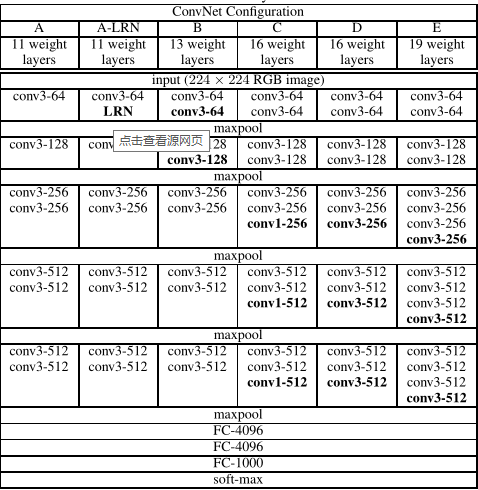

# SSD网络图
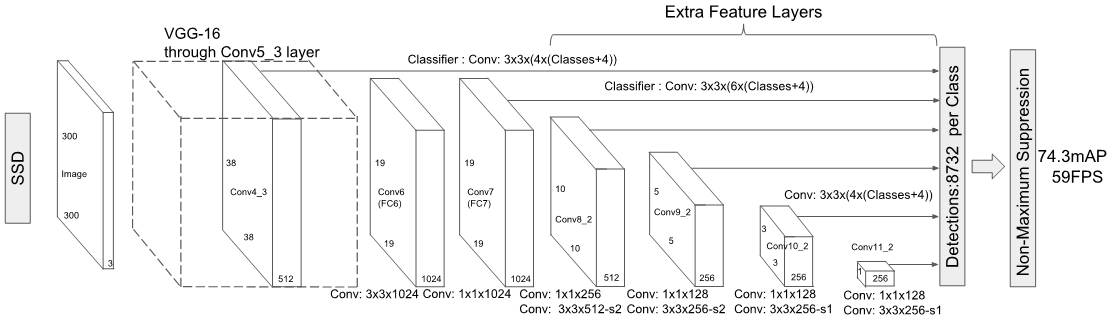

In [24]:
class VGG16x(object):
    def __init__(self , is_training=True):
        
        self.x = tf.placeholder(dtype=tf.float32 , shape=[1 , 300 , 300 , 3])        
        
        self.build(is_training)
        
        if is_training:
            self.y = tf.placeholder(dtype=tf.float32 , shape=[1 , 13 , 13 , 5 , (5+20)])
            self.loss(is_training)

    def build(self , is_training):
        #arch from paper
        def _batch_norm(_input , is_training):
            return slim.batch_norm(_input , is_training=is_training) #
        
        def _weight_variable(shape , name):
            return tf.get_variable('weights_'+name , shape=shape , dtype=tf.float32 ,
                                    initializer = tf.initializers.truncated_normal(stddev=0.01) , trainable = True)
        
        def _bias_variable(shape , name):
            return tf.get_variable('biases_'+name , shape=shape , dtype=tf.float32 ,
                                    initializer = tf.initializers.constant(0.0))
        
        def _conv(_input , num_outputs , kernel_size , stride=1 , padding='SAME' , name='default' , dilations=[1,1,1,1] , is_activation = True):
            weight = _weight_variable(shape=[kernel_size , kernel_size , _input.get_shape().as_list()[-1] , num_outputs] , name=name)
            biases = _bias_variable(shape=[num_outputs] , name=name)
            
            if is_activation:
                return tf.nn.relu( _batch_norm( tf.nn.conv2d(_input , weight , strides=[1,stride,stride,1] , padding=padding , dilations=dilations) + biases , is_training))
            else:
                return _batch_norm( tf.nn.conv2d(_input , weight , strides=[1,stride,stride,1] , padding=padding , dilations=dilations) + biases , is_training)

                          
        def _max_pool(_input , kernel_size=2 , stride=2 , padding='SAME' , name='default'): #name参数没用
            return slim.max_pool2d(_input , kernel_size=kernel_size , stride=stride , padding=padding)
        
        self.loc = []
        self.logits = []
        self.probs = []
        
        #_conv中已放入batch-norm
        #VGG16
        output = _conv(self.x , 64 , 3 , name='conv1_1')
        output = _conv(output , 64 , 3 , name='conv1_2')              
        output = _max_pool(output , name='pool1')
        
        output = _conv(output , 128 , 3 , name='conv2_1')
        output = _conv(output , 128 , 3 , name='conv2_2')
        output = _max_pool(output , name='pool2')
        
        output = _conv(output , 256 , 3 , name='conv3_1')
        output = _conv(output , 256 , 3 , name='conv3_2')
        output = _conv(output , 256 , 3 , name='conv3_3')
        output = _max_pool(output , name='pool3')
        
        output = _conv(output , 512 , 3 , name='conv4_1')
        output = _conv(output , 512 , 3 , name='conv4_2')
        output = _conv(output , 512 , 3 , name='conv4_3')
        output = nn.l2_normalize(output , axis=-1) #对VGG16的feature进行L2归一化
        
        loc = _conv(output , 4*4 , 3 , name='detect1_loc' , is_activation=False) #38*38
        loc = tf.reshape(loc , [1 , 38 , 38 , 4 , 4])
        logits = _conv(output , 4*21 , 3 , name='detect1_logits' , is_activation=False)
        logits = tf.reshape(logits , [1,38,38,4,21])
        probs = tf.nn.softmax(logits)
        self.loc.append(loc)
        self.logits.append(logits)
        self.probs.append(probs)
        
        output = _max_pool(output , name='pool4')
        
        output = _conv(output , 512 , 3 , name='conv5_1')
        output = _conv(output , 512 , 3 , name='conv5_2')
        output = _conv(output , 512 , 3 , name='conv5_3')
        output = _max_pool(output , kernel_size=3 , stride=1 , name='pool5') #SSD修改
        
        output = _conv(output , 1024 , 3 , name='conv6' , dilations=[1,6,6,1]) #扩展卷积了
        
        output = _conv(output , 1024 , 1 , name='conv7')
        
        loc = _conv(output , 6*4 , 3 , name='detect2_loc' , is_activation=False) #19*19
        loc = tf.reshape(loc , [1 , 19 , 19 , 6 , 4])
        logits = _conv(output , 6*21 , 3 , name='detect2_logits' , is_activation=False)
        logits = tf.reshape(logits , [1,19,19,6,21])
        probs = tf.nn.softmax(logits)
        self.loc.append(loc)
        self.logits.append(logits)
        self.probs.append(probs)
        
        output = _conv(output , 256 , 1 , name='conv8_1')
        output = _conv(output , 512 , 3 , 2 , name='conv8_2')
        
        loc = _conv(output , 6*4 , 3 , name='detect3_loc' , is_activation=False) #10*10
        loc = tf.reshape(loc , [1 , 10 , 10 , 6 , 4])
        logits = _conv(output , 6*21 , 3 , name='detect3_logits' , is_activation=False)
        logits = tf.reshape(logits , [1,10,10,6,21])
        probs = tf.nn.softmax(logits)
        self.loc.append(loc)
        self.logits.append(logits)
        self.probs.append(probs)
        
        output = _conv(output , 128 , 1 , name='conv9_1')
        output = _conv(output , 256 , 3 , 2 , name='conv9_2')
        
        loc = _conv(output , 6*4 , 3 , name='detect4_loc' , is_activation=False) #5*5
        loc = tf.reshape(loc , [1 , 5 , 5 , 6 , 4])
        logits = _conv(output , 6*21 , 3 , name='detect4_logits' , is_activation=False)
        logits = tf.reshape(logits , [1,5,5,6,21])
        probs = tf.nn.softmax(logits)
        self.loc.append(loc)
        self.logits.append(logits)
        self.probs.append(probs)
        
        output = _conv(output , 128 , 1 , name='conv10_1')
        output = _conv(output , 256 , 3 , 2 , name='conv10_2')
        
        loc = _conv(output , 4*4 , 3 , name='detect5_loc' , is_activation=False) #3*3
        loc = tf.reshape(loc , [1 , 3 , 3 , 4 , 4])
        logits = _conv(output , 4*21 , 3 , name='detect5_logits' , is_activation=False)
        logits = tf.reshape(logits , [1,3,3,4,21])
        probs = tf.nn.softmax(logits)
        self.loc.append(loc)
        self.logits.append(logits)
        self.probs.append(probs)
        
        output = _conv(output , 128 , 1 , name='conv11_1')
        output = _conv(output , 256 , 3 , 2 , padding='VALID' , name='conv11_2')
        
        loc = _conv(output , 4*4 , 3 , name='detect6_loc' , is_activation=False) #1*1
        loc = tf.reshape(loc , [1 , 1 , 1 , 4 , 4])
        logits = _conv(output , 4*21 , 3 , name='detect6_logits' , is_activation=False)
        logits = tf.reshape(logits , [1,1,1,4,21])
        probs = tf.nn.softmax(logits)
        self.loc.append(loc)
        self.logits.append(logits)
        self.probs.append(probs)
        
        
    def loss(self , is_training):
        pass

In [25]:
tf.reset_default_graph()

In [26]:
test = VGG16x(is_training=False)

In [28]:
test.loc

[<tf.Tensor 'Reshape:0' shape=(1, 38, 38, 4, 4) dtype=float32>,
 <tf.Tensor 'Reshape_4:0' shape=(1, 19, 19, 6, 4) dtype=float32>,
 <tf.Tensor 'Reshape_8:0' shape=(1, 10, 10, 6, 4) dtype=float32>,
 <tf.Tensor 'Reshape_12:0' shape=(1, 5, 5, 6, 4) dtype=float32>,
 <tf.Tensor 'Reshape_16:0' shape=(1, 3, 3, 4, 4) dtype=float32>,
 <tf.Tensor 'Reshape_20:0' shape=(1, 1, 1, 4, 4) dtype=float32>]

In [67]:
def display(image , pred_boxes , name):    
    im_h = image.shape[0]
    im_w = image.shape[1]
    
    output = image.copy()
    
    for box in pred_boxes:
        overlay = output.copy()
        
        class_idx = np.argmax(box[5:])
        
        x_min , x_max = [int(x * im_w) for x in [box[0] , box[2]]] #由比例单位转为图中的坐标系
        y_min , y_max = [int(x * im_h) for y in [box[1] , box[3]]]
        
        cv2.rectangle(overlay , (x_min , y_min) , (x_max , y_max) , (255,255,255))

        output = cv2.putText(overlay , LABEL2STR[np.argmax(box[5:])] , org=(x1 , y1+10) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = (255,255,255), thickness = 1)

    #plt.imshow(meta_img) #图像查看

    plt.imsave(arr=image[: , : ,[2,1,0]] , fname = 'result/%s.jpg' % name) #保存图像


In [73]:
class SSD(object):
    '''
    完整模型
    '''
    
    def __init__(self , is_training = True):
        self.dataset = Dataset()
        
        self.filewriter_path = 'save/logs' #模型可视化
        self.checkpoint_path = 'save/model/' #模型持久化
                              
        self.model = VGG16x(is_training)
        
        self.sess = tf.Session()
        
        self.saver = tf.train.Saver(max_to_keep=2) #max_to_keep 最大保存5次模型  之后继续保存则会覆盖前面的模型
        
        if is_training:
            '''训练参数'''
            self.epoch = 100000
            
            self.global_step = tf.Variable(initial_value=0 , trainable=False)
            
            self.learning_rate = tf.train.exponential_decay(learning_rate=0.00001 , global_step=self.global_step,
                                                            decay_steps=900 , decay_rate=0.8 , staircase=True)
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.model.total_loss , global_step=self.global_step)
        
            #引入滑动平均
            self.ema = tf.train.ExponentialMovingAverage(decay=0.9) #滑动平均
            self.average_op = self.ema.apply(tf.trainable_variables()) #给所有的可训练变量应用滑动平均
            
            with tf.control_dependencies([self.optimizer]):
                self.train_op = tf.group(self.average_op)
            
            '''可视化'''
            self.sess.run(tf.global_variables_initializer())
            
            tf.summary.scalar('total_loss' , self.model.total_loss)
            self.merged_summary = tf.summary.merge_all() #merge all summaries in the default graph
            self.writer = tf.summary.FileWriter(self.filewriter_path , self.sess.graph) #可视化
            
    
    def train(self):
        if os.path.exists(self.checkpoint_path+'checkpoint'):
            self.saver.restore(self.sess , tf.train.latest_checkpoint(self.checkpoint_path))
        else:
            self.sess.run(tf.global_variables_initializer())
        
        for i in range(300):
            x , labels = self.dataset.get_batch()
            
            self.sess.run(self.train_op , feed_dict={self.model.x : x , self.model.y : labels} )

            if i % 10 == 0:
                self.saver.save(self.sess , self.checkpoint_path + 'model.ckpt' , global_step = i)
                
                total_loss , summary = self.sess.run([self.model.total_loss , self.merged_summary] , feed_dict={self.model.x : x , self.model.y : labels})
                        
                self.writer.add_summary(summary , global_step = i)
                                
                print(i , total_loss)
            
        self.writer.close() #event to disk and close the file

    def predict(self , path=None , conf_thres = 0.5 , iou_thres = 0.5):
        if os.path.exists(self.checkpoint_path + 'checkpoint'):
            self.saver.restore(self.sess , tf.train.latest_checkpoint(self.checkpoint_path) )
            
            self._predict(path , conf_thres , iou_thres)
        else:
            print('no model!!!')
            return 
            
    def _predict(self , path , conf_thres , iou_thres):
        # threshold_1 = 0.01
        # threshold_nms = 0.7
        
        x , img_arr = self.dataset.get_batch_test(path)
        
        output = self.sess.run(self.model.pred_y , feed_dict={self.model.x : x})
        
        self._output = output
        
        #依次是 左上坐标 右下坐标 confidence softmax概率
        boxes = np.reshape(output , (output.shape[0] , -1 , output.shape[-1])) #shape变为 [batch_size 13*13*5 25]
        nms_boxes = []
        
        for box in boxes: #一次处理batch中的一张图片
            '''
            box的尺寸为 [13*13*5 25]
            '''
            nms_box = self.nms(box , conf_thres , iou_thres)
            nms_boxes.append(nms_box)
        
        nms_boxes = np.array(nms_boxes)
        
        '''
        下面的写法是因为不满足条件的预测框（confidence分数低于阈值） 25维向量元素全置为0 所以使用any（逻辑或）函数可以找见全0元素的索引
        '''
        bboxes = nms_boxes[np.nonzero( np.any(nms_boxes>0 , axis=1) ) ]
        
        display(img_arr , bboxes , 'first')
        

    def nms(self , boxes , conf_thres , iou_thres):
        '''
        iou需要小于指定的阈值
        confidence需要大于指定的阈值
        '''
        '''
        一次处理一张图片对应的网络给出结果
        boxes的尺寸为[13*13*5 25]
        '''
        '''
        对所有的预测框进行nms过程 不是分别对每个类别进行nms
        '''
        #左上 右下坐标 均为比例值 (0 1)范围之间
        x1 = boxes[... , 0]
        y1 = boxes[... , 1]
        x2 = boxes[... , 2]
        y2 = boxes[... , 3]
        
        areas = (x2-x1)*(y2-y1)
        scores = boxes[... , 4]
        
        keep = []
        order = scores.argsort()[::-1] #逆序变为升序排列的index argsort是升序排列的index
        
        while order.size > 0:
            i = order[0]
            keep.append(i)
            
            #下面的比较使用numpy的广播机制 先变成与第二个参数长度一样的 在进行比较 返回最大值
            xx1 = np.maximum(x1[i] , x1[order[1:]])
            yy1 = np.maximum(y1[i] , y1[order[1:]])
            xx2 = np.maximum(x2[i] , x2[order[1:]])
            yy2 = np.maximum(y2[i] , y2[order[1:]])
            
            w = np.maximum(0.0 , xx2-xx1)
            h = np.maximum(0.0 , yy2-yy1)
            
            inter = w*h
            ovr = inter/(areas[i] + areas[order[1:]] - inter)
            
            inds = np.where(ovr <= iou_thres)[0] #np.where() 返回满足条件的索引
            
            order = order[inds + 1]
    
        nms_box = []
        for idx in range(len(boxes)):
            if idx in keep and boxes[idx , 4] > conf_thres:
                nms_box.append(boxes[idx]) #25个元素
            else:
                nms_box.append(np.zeros(boxes.shape[-1])) #25个0
                
        return np.array(nms_box)

In [74]:
tf.reset_default_graph()

In [18]:
test = YOLO_V2()

In [19]:
test.train()

0 0.56849897
10 1.6498395
20 1.0492408
30 1.2971392
40 0.47714478
50 1.7881955
60 0.5152417
70 0.49427003
80 0.4440512
90 0.63722193
100 2.341517
110 0.39328712
120 0.6648505
130 0.47405463
140 1.3099298
150 0.37105387
160 0.5389808
170 0.3525883
180 1.6754111
190 1.8742914
200 0.45636827
210 1.0451202
220 0.22119105
230 0.4433879
240 0.54642904
250 0.47717527
260 0.48467034
270 1.4043194
280 0.56810254
290 0.3311335


In [69]:
tf.reset_default_graph()

In [75]:
testt = YOLO_V2(is_training=False)

In [77]:
testt.predict()

INFO:tensorflow:Restoring parameters from save/model/model.ckpt-290
